# Tarea 2 Inteligencia Artificial
# Alumno: Javier Ramos

---
###Parte 1 - Investigacion:
Para esta parte de la tarea se pide realizar una investigacion sobre dos temas, los Extended Kalman Filters y los Unscented Kalman Filters, para luego realizar una comparacion de ambos metodos, se hace una explicacion de lo encontrado y ademas las referencias correspondientes se indican en la seccion "Referencias" al final de la tarea:

###- Extended Kalman Filters (EKF):
Sabemos de antemano (por la materia vista en el ramo), que los filtros de Kalman se manejan en definiciones basadas en sistemas Lineales y que no deben ser usados en entornos no lineales, este es el campo donde entran los Filtros de Kalman, como podemos ver en [1], "Los Filtros de Kalman extendidos son la version no-lineal de los filtros de Kalman, que linealizan un estimado del promedio y la covarianza. Los EKF son considerados los filtros estandar para estimacion de estados no lineales, sistemas de navegacion y GPS". Cabe mencionar que los filtros extendidos no son una implementacion optima y que a diferencia de los filtros de Kalman, si la linealizacion consecutiva no es una buena aproximacion al modelo lineal, estos filtros pueden diverger [2].

###- Unscented Kalman Filters (UKF):
El Unscented Kalman Filter nace como una solucion al problema principal que tienen los filtros extendidos de Kalman, siendo este la propagacion del error asociado a la linealizacion de las variables gaussianas aleatorias asociadas a un sistema no lineal que es linealizado, con distintas operaciones matematicas, aunque al parecer la mas utilizada es la Serie de Taylor [3], cosa de luego ser utilizado en la prediccion de un estado discreto. El UKF aborda este problema utilizando muestreo determinista, donde se usa el mismo metodo para generar los estados aleatorios, pero ahora se utiliza un conjunto cuidadosamente seleccionado, el cual logra representar de mejor forma la media y la covarianza del Variables Gaussianas Aleatorias (GRV) hasta un orden de tercer grado por la expansion de Serie de Taylor [4].

##Comparacion:
Con las lecturas realizadas, se entiende que el Unscented Kalman Filter llega a ser más preciso, dado que soluciona los problemas que se propagan por la linealizacion de sistemas no lineales, ademas de que es más barato y rapido de ejecutar computacionalmente, esto se debe a que en EKF se debe linealizar --- mientras que en UFK se linealizan los puntos que presentan el ruido gaussiano y luego se filtran meticulosamente para que representen mejor la distribucion de la media y la covarianza, aunque en [5], se muestra una implementacion de UKF que involucra metodos de fusion con distintos inputs utilizados en sistemas de GPS, y en este caso se da que es computacionalmente más costoso que EKF, manteniendo la precision, que podriamos decir que seria su caracteristica principal, mientras que la performance dependeria del entorno en el que se usa.


In [ ]:
!pip install -q --upgrade matplotlib
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Parte 2 - Grafico Trayectoria:
En esta parte se importa el codigo "ufk.py" y el "datos.csv" desde Google Drive, en el siguiente cuadro de codigo se debe cambiar la direccion desde "MyDrive/..." a la dirección donde tiene almacenado los archivos en drive (se puede ver en la parte de archivos a la izquierda) o tambien pueden importarse directamente desde la misma seccion de archivos. Ademas se importa la libreria de matplotlib, la cual se utilizara para generar los graficos.

In [ ]:
!cp drive/MyDrive/ColabNotebooks/Librerias/ukf.py .
!cp drive/MyDrive/ColabNotebooks/Datasets/datos.csv .
import ukf
import matplotlib as mpl
import matplotlib.pyplot as plt

En el siguiente cuadro de código se copio el archivo tarea2.py directamente desde el entregado en el enunciado y se le hicieron pequeñas modificaciones, las cuales corresponden a la creacion de variables para almacenar las posiciones estimadas y las posiciones reales del submarino, solo para facilitar su posterior graficacion.

In [ ]:
from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


np.set_printoptions(precision=3)

# Process Noise
q = np.eye(6)
q[0][0] = 0.0001
q[1][1] = 0.0001
q[2][2] = 0.0004
q[3][3] = 0.0025
q[4][4] = 0.0025
q[5][5] = 0.0025

# create measurement noise covariance matrices
r_imu = np.zeros([2, 2])
r_imu[0][0] = 0.01
r_imu[1][1] = 0.03

r_compass = np.zeros([1, 1])
r_compass[0][0] = 0.02

r_encoder = np.zeros([1, 1])
r_encoder[0][0] = 0.001

# pass all the parameters into the UKF!
# number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

#Variables que se utilizaran para Graficar, se modifico el codigo solo para facilitar la creacion de los graficos, ademas de
# arreglar un error con el metodo .next().
real = []
estimated = []
difference = []

with open('datos.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    last_time = 0
    # read data
    for row in reader:
        row = [float(x) for x in row]

        cur_time = row[0]
        d_time = cur_time - last_time
        real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

        # create an array for the data from each sensor
        compass_hdg = row[9]
        compass_data = np.array([compass_hdg])

        encoder_vel = row[10]
        encoder_data = np.array([encoder_vel])

        imu_accel = row[7]
        imu_yaw_rate = row[8]
        imu_data = np.array([imu_yaw_rate, imu_accel])

        last_time = cur_time

        # prediction is pretty simple
        state_estimator.predict(d_time)

        # updating isn't bad either
        # remember that the updated states should be zero-indexed
        # the states should also be in the order of the noise and data matrices
        state_estimator.update([4, 5], imu_data, r_imu)
        state_estimator.update([2], compass_data, r_compass)
        state_estimator.update([3], encoder_vel, r_encoder)

        print ("--------------------------------------------------------")
        print (f'Real state: {real_state}')
        print (f'Estimated state: {state_estimator.get_state()}')
        print (f'Difference: { real_state - state_estimator.get_state()}')

        #Se guardan los valores calculados en variables que seran utilizadas en el desarrollo de la tarea.

        real.append(real_state)
        estimated.append(state_estimator.get_state())
        difference.append( real_state - state_estimator.get_state() )

--------------------------------------------------------
Real state: [0.    0.    0.    0.    0.459 1.044]
Estimated state: [2.018e-05 0.000e+00 8.451e-05 1.057e-03 4.256e-03 2.979e-03]
Difference: [-2.018e-05  0.000e+00 -8.451e-05 -1.057e-03  4.549e-01  1.041e+00]
--------------------------------------------------------
Real state: [ 0.009 -0.003 -0.008  0.058  0.543  1.008]
Estimated state: [5.326e-04 2.222e-09 1.437e-04 1.237e-02 1.496e-02 1.259e-02]
Difference: [ 0.008 -0.003 -0.008  0.046  0.528  0.995]
--------------------------------------------------------
Real state: [0.016 0.003 0.028 0.13  0.463 1.06 ]
Estimated state: [3.602e-03 1.030e-06 2.627e-03 5.401e-02 2.720e-02 2.503e-02]
Difference: [0.013 0.003 0.025 0.076 0.436 1.035]
--------------------------------------------------------
Real state: [0.03  0.002 0.028 0.256 0.544 1.042]
Estimated state: [1.111e-02 1.841e-05 6.577e-03 1.203e-01 5.078e-02 4.419e-02]
Difference: [0.019 0.002 0.021 0.136 0.493 0.998]
--------------

*( Si al ejecutar la siguiente celda de codigo retorna un error por layout, porfavor ir a "Entorno de ejecucion" y luego seleccionar "Reiniciar entorno de ejecucion" y correr todas las celdas hasta este punto, esto deberia solucionar el problema que genera matplotlib )*

Text(0.5, 1.0, 'Grafico Posicion Estimada Submarino')

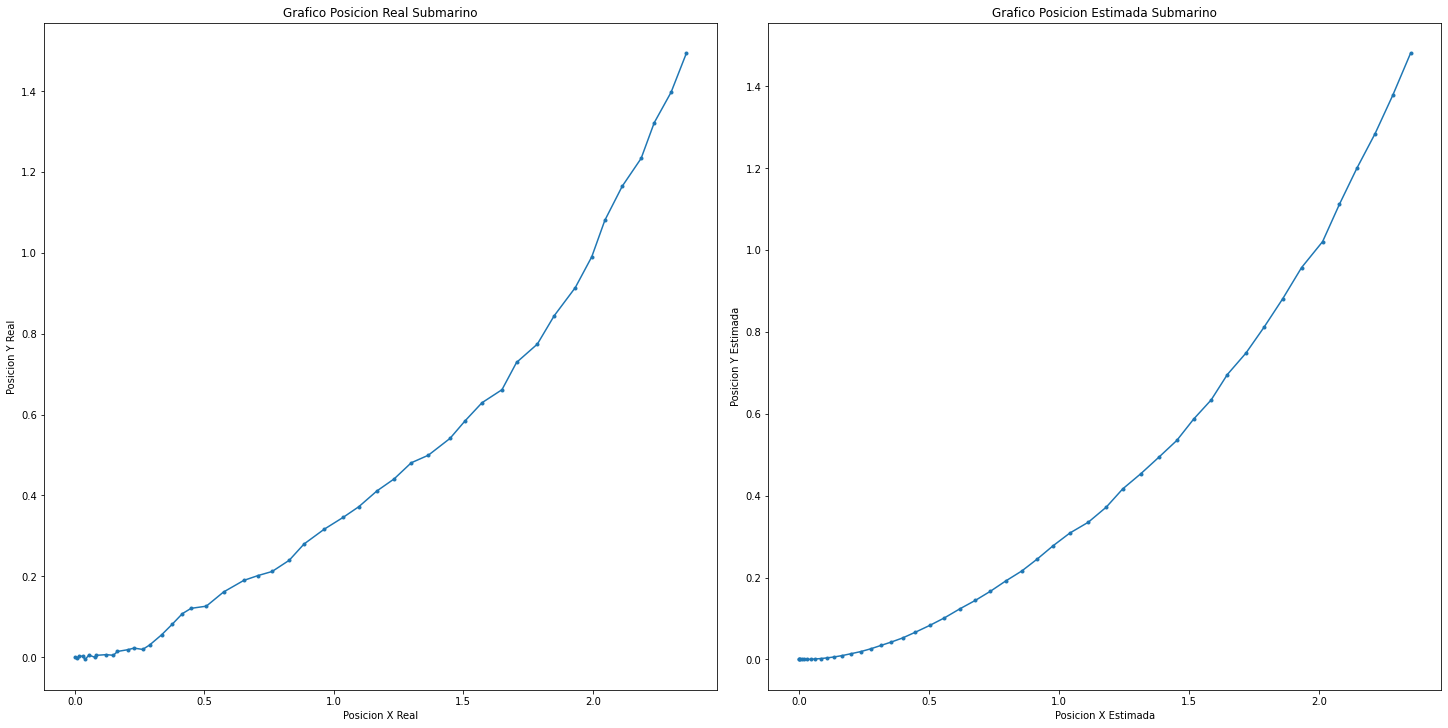

In [ ]:
graph = plt.figure(figsize=(20, 10), layout='constrained')
plot1 = graph.add_subplot(121)
plot2 = graph.add_subplot(122)

realx = []
realy = []
estimatedx = []
estimatedy = []

for i in range(len(real)):
  realx.append(real[i][0])
  realy.append(real[i][1])
  estimatedx.append(estimated[i][0])
  estimatedy.append(estimated[i][1])


plot1.plot(realx,realy,marker=".")
plot1.set_xlabel('Posicion X Real')
plot1.set_ylabel('Posicion Y Real')
plot1.set_title("Grafico Posicion Real Submarino")

plot2.plot(estimatedx,estimatedy,marker=".")
plot2.set_xlabel('Posicion X Estimada')
plot2.set_ylabel('Posicion Y Estimada')
plot2.set_title("Grafico Posicion Estimada Submarino")

Una vez ya graficado se puede ver que la curva estimada presenta muchas menos perturbaciones en su trayectoria que la grafica del estado real del submarino.

###Parte 3 - Variando cantidad de Sensores:

En esta parte se modifica el codigo de tarea2, principalmente se cambio la funcion main por una funcion definida para facilitar su ejecución, llamada "ukf_function", ademas se pide que se entregue el parametro [filtros] a la funcion, el cual corresponde a una lista con los filtros a utilizar, donde:
 el 1 es imu, el 2 es compass y el 3 los encoders,
  

*   1 -> Corresponde a usar el Sensor IMU.
*   2 -> Corresponde a usar el Compass.
*   3 -> Corresponde a usar los encoders.
*  [] -> Corresponde a no usar sensores para ajustar.

Esto se logro agregando un ciclo for que recorre la lista filtros y dependiendo del numero, ejecuta su update correspondiente.


In [ ]:
from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret

def ukf_function(filtros):
  np.set_printoptions(precision=3)

  # Process Noise
  q = np.eye(6)
  q[0][0] = 0.0001
  q[1][1] = 0.0001
  q[2][2] = 0.0004
  q[3][3] = 0.0025
  q[4][4] = 0.0025
  q[5][5] = 0.0025

  # create measurement noise covariance matrices
  r_imu = np.zeros([2, 2])
  r_imu[0][0] = 0.01
  r_imu[1][1] = 0.03

  r_compass = np.zeros([1, 1])
  r_compass[0][0] = 0.02

  r_encoder = np.zeros([1, 1])
  r_encoder[0][0] = 0.001

  # pass all the parameters into the UKF!
  # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
  state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

  #Variables que se utilizaran para Graficar, se modifico el codigo solo para facilitar la creacion de los graficos, ademas de
  # arreglar un error con el metodo .next().
  real2 = []
  estimated2 = []
  difference2 = []

  with open('datos.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    last_time = 0
    # read data
    for row in reader:
      row = [float(x) for x in row]

      cur_time = row[0]
      d_time = cur_time - last_time
      real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

      # create an array for the data from each sensor
      compass_hdg = row[9]
      compass_data = np.array([compass_hdg])

      encoder_vel = row[10]
      encoder_data = np.array([encoder_vel])

      imu_accel = row[7]
      imu_yaw_rate = row[8]
      imu_data = np.array([imu_yaw_rate, imu_accel])

      last_time = cur_time

      # prediction is pretty simple
      state_estimator.predict(d_time)

      # updating isn't bad either
      # remember that the updated states should be zero-indexed
      # the states should also be in the order of the noise and data matrices
      for i in filtros:
        if i==1:
          state_estimator.update([4, 5], imu_data, r_imu)
        if i==2:
          state_estimator.update([2], compass_data, r_compass)
        if i==3:
          state_estimator.update([3], encoder_vel, r_encoder)

      #Se guardan los valores calculados en variables que seran utilizadas en el desarrollo de la tarea.

      real2.append(real_state)
      estimated2.append(state_estimator.get_state())
      difference2.append( real_state - state_estimator.get_state() )

    #Se generan los layouts de los graficos.
    graph = plt.figure(figsize=(20, 10), layout='constrained')
    plot1 = graph.add_subplot(121)
    plot2 = graph.add_subplot(122)

    realx = []
    realy = []
    estimatedx = []
    estimatedy = []

    #Se recorren las variables del codigo y se almacenan los datos para luego ser graficados.
    for i in range(len(real)):
      realx.append(real2[i][0])
      realy.append(real2[i][1])
      estimatedx.append(estimated2[i][0])
      estimatedy.append(estimated2[i][1])

    #Se grafican los datos y se asignan valores a los ejes y nombres a los graficos.
    plot1.plot(realx,realy,marker=".")
    plot1.set_xlabel('Posicion X Real')
    plot1.set_ylabel('Posicion Y Real')
    plot1.set_title("Grafico Posicion Real Submarino")

    plot2.plot(estimatedx,estimatedy,marker=".")
    plot2.set_xlabel('Posicion X Estimada')
    plot2.set_ylabel('Posicion Y Estimada')
    plot2.set_title("Grafico Posicion Estimada Submarino")

Se procede entonces a probar las distintas combinaciones de filtros, partiendo por no usar filtros:

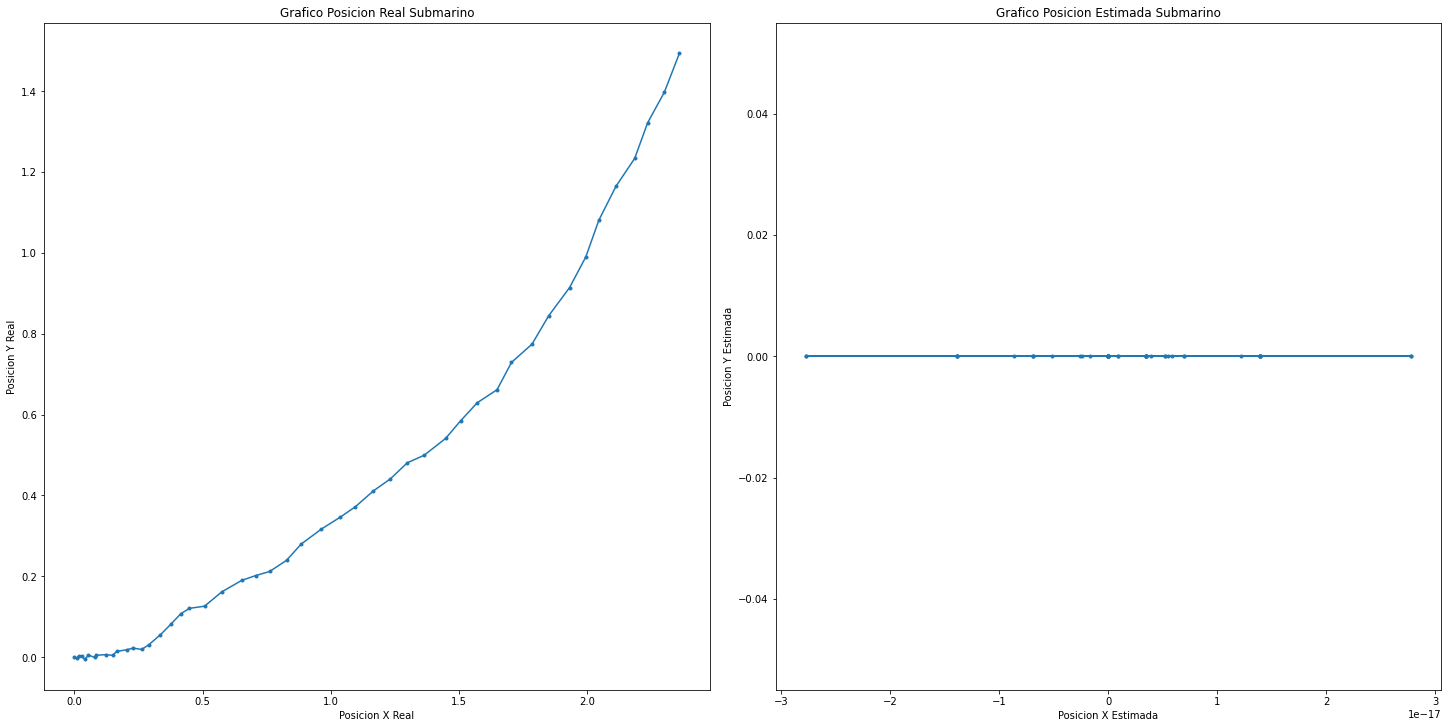

In [ ]:
ukf_function([])

Se ve que al no usar las actualizaciones que aportan los sensores, se genera una funcion que es constante en Y=0, esto puede deberse a que al no tener ayuda de ningun otro sensor, el filtro unscented solo persive que el submarino se mueve linealmente en el eje x

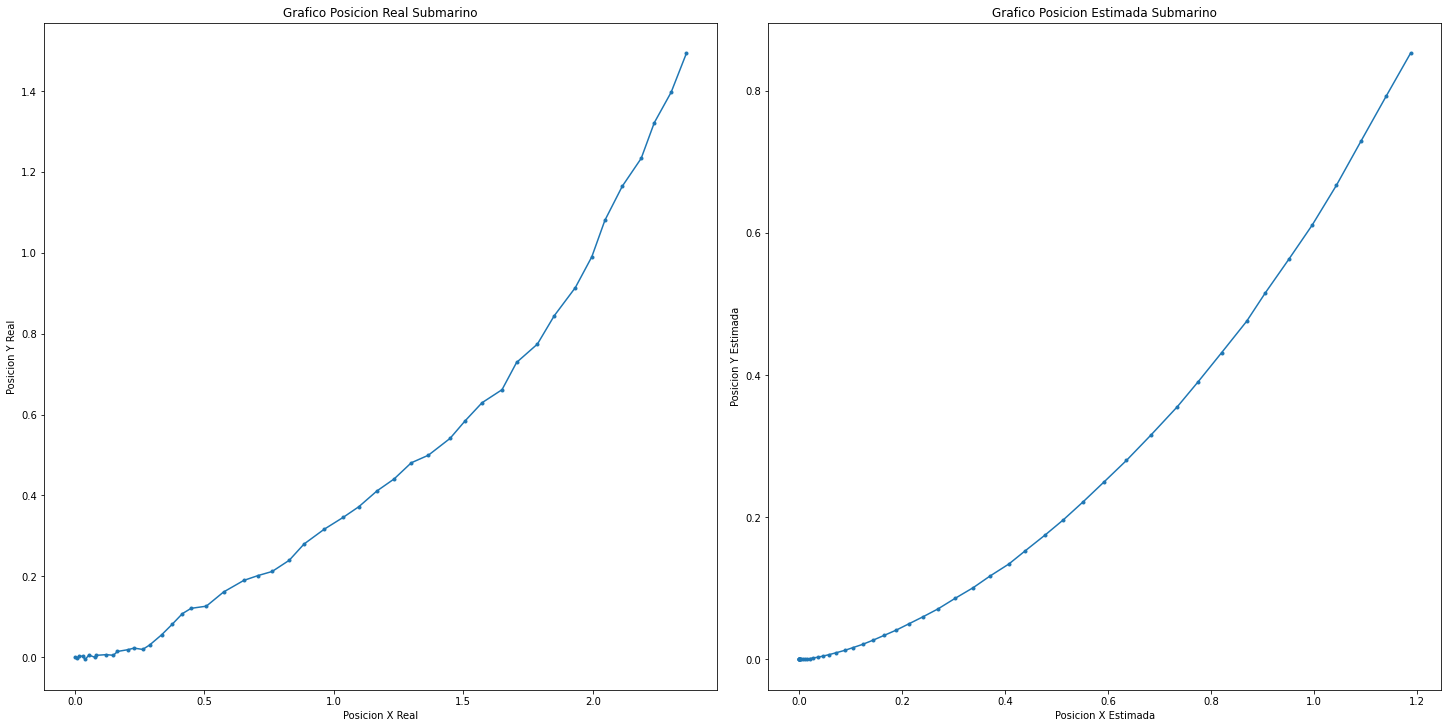

In [ ]:
ukf_function([1])

En este caso se ve que al pasar los datos estimados por el IMU solo genera una curva muy similar a una de euler ( e^x ), la cual no presenta imperfecciones. Esto puede ser dado que el imu solo aporta informacion sobre la velocidad longitudinal y la velocidad angular, por lo que su posicion se ve modificada de manera constante y eso explica el comportamiento de la curva.

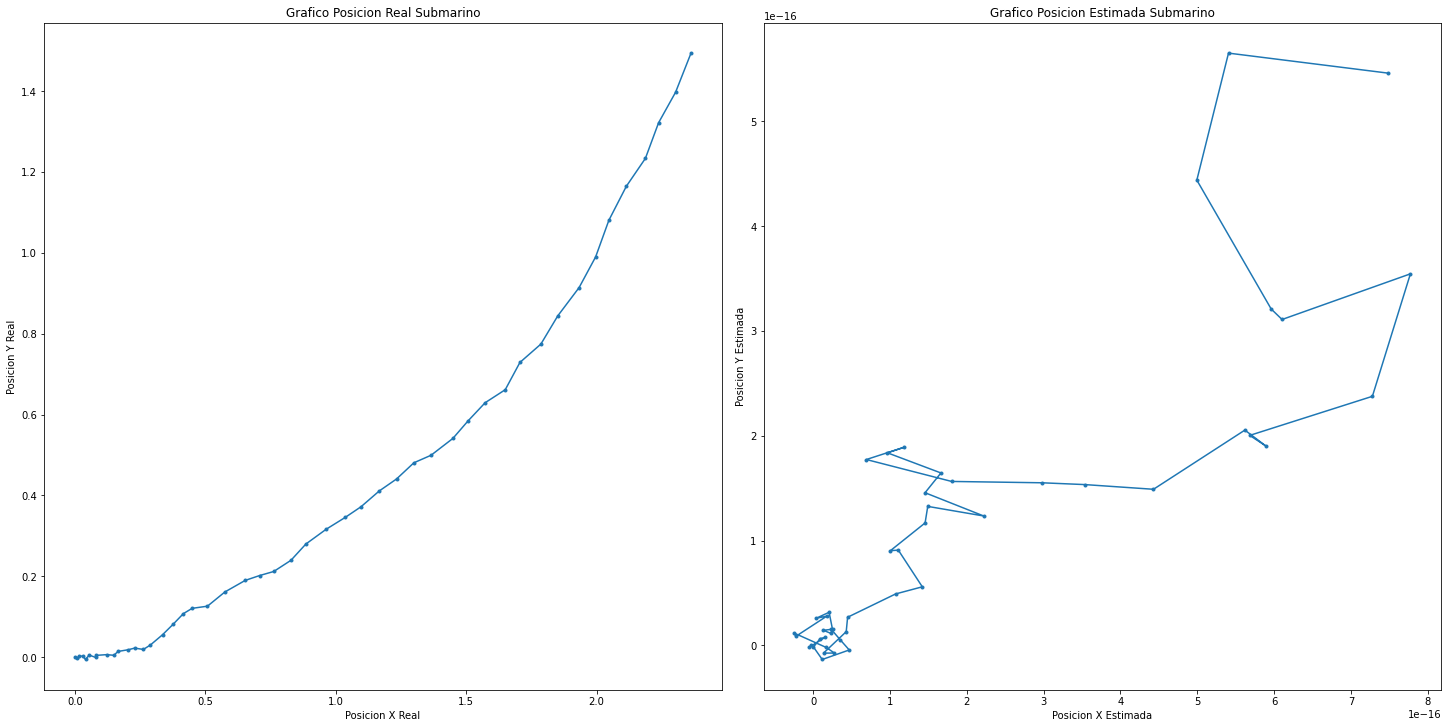

In [ ]:
ukf_function([2])

Este grafico es el que se genera al pasar la posicion estimada por el compass, dado que el compass obtiene datos de los angulos, esto genera más variaciones dado que estos pueden variar en cosa de segundo por corrientes o distintas perturbaciones en el submarino, de forma mucho mas rapida y erratica.

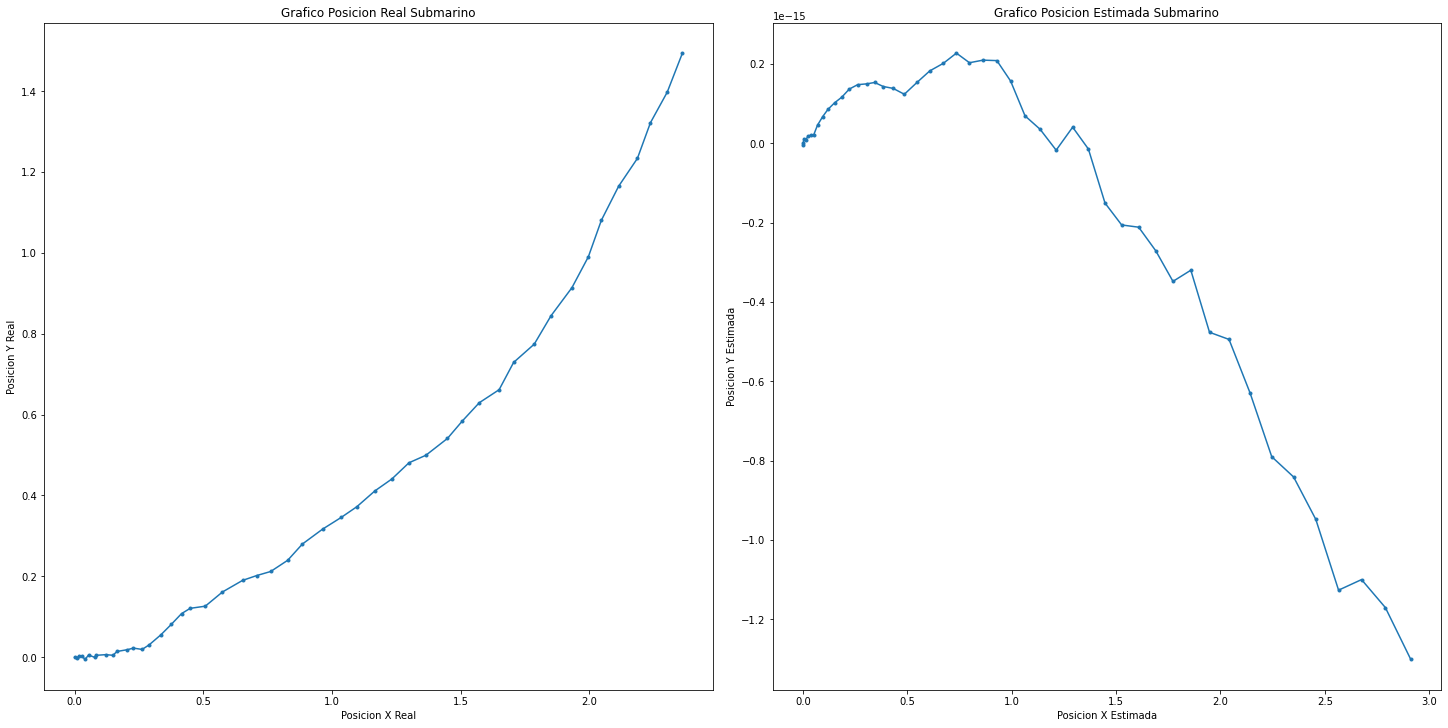

In [ ]:
ukf_function([3])

Dada la curva de actualizacion de la posicion real que se tiene, se puede ver que los datos actualizados solo con los encoders, permiten visualizar como la velocidad del submarino va disminuyendo a medida que la altura "deberia ir aumentando".

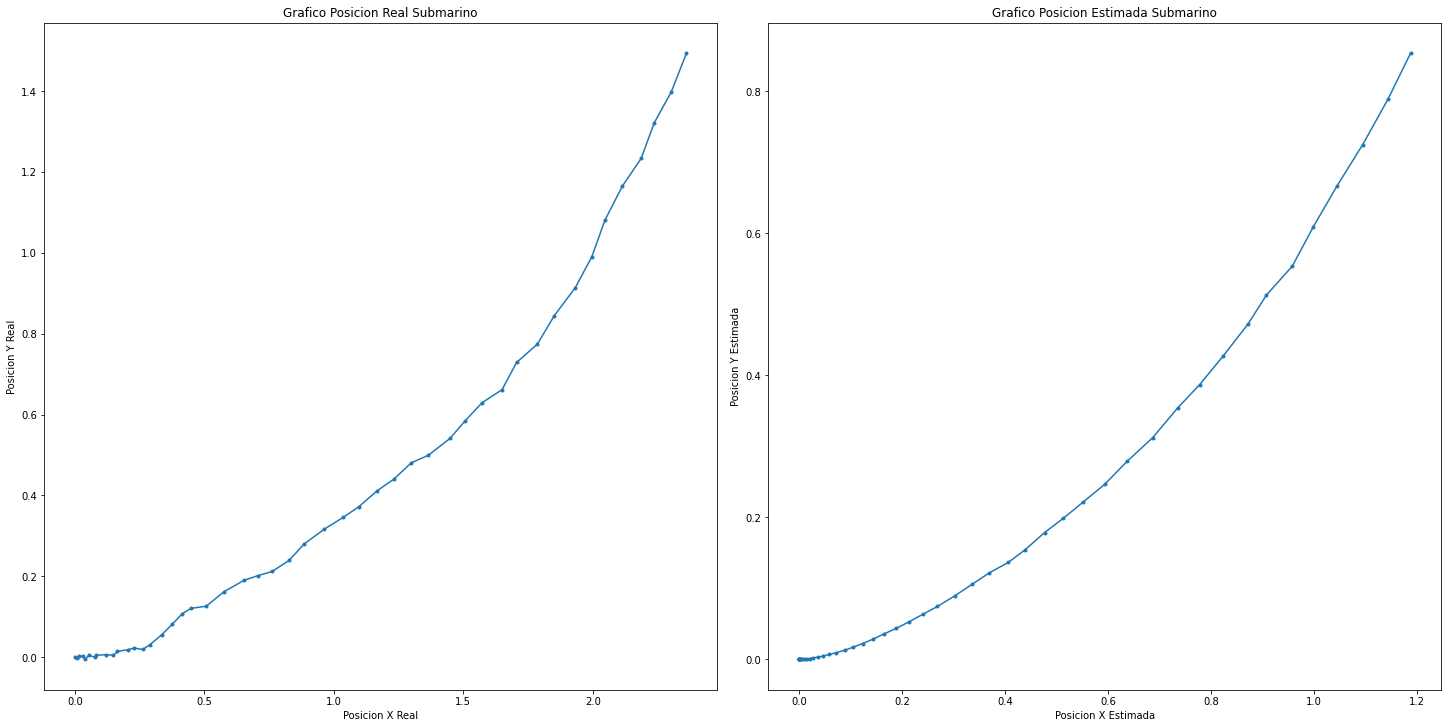

In [ ]:
ukf_function([1,2])

Podemos ver en este caso que el grafico consigue algunas perturbaciones y logra modelar de mejor forma la posicion real, ya que en este escenario estamos frente a un grafico con IMU y con Compass, por lo que tenemos tanto información de la profundidad del submarino, como de la dirección o inclinacion en la que se esta moviendo.

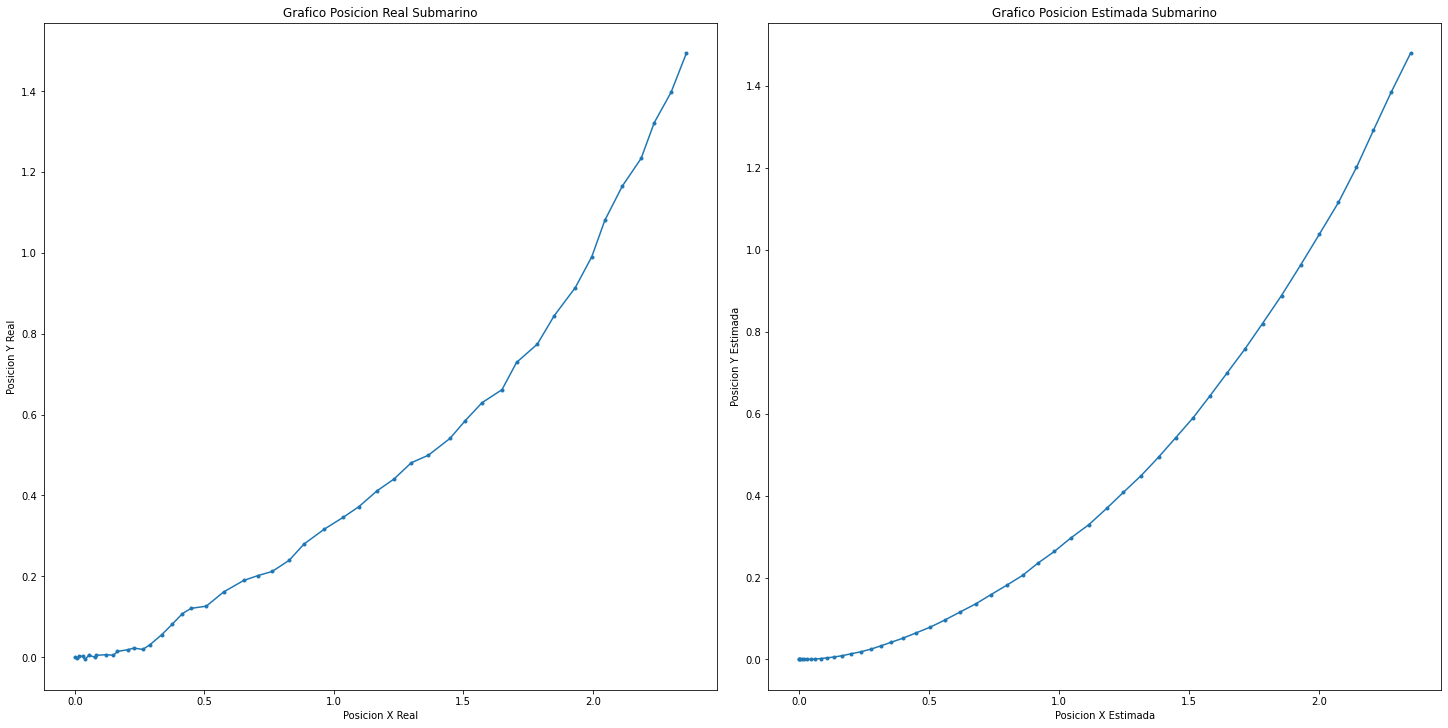

In [ ]:
ukf_function([1,3])

En este caso, en el cual solo tenemos IMU y encoders, no se nota mucha diferencia respecto a solo IMU, lo cual igual tiene sentido, dado que el aporte de informacion es respecto a la velocidad y su pendiente aporta información en cuanto a la aceleracion, ambos puntos que no se ven reflejados directamente en la posición.

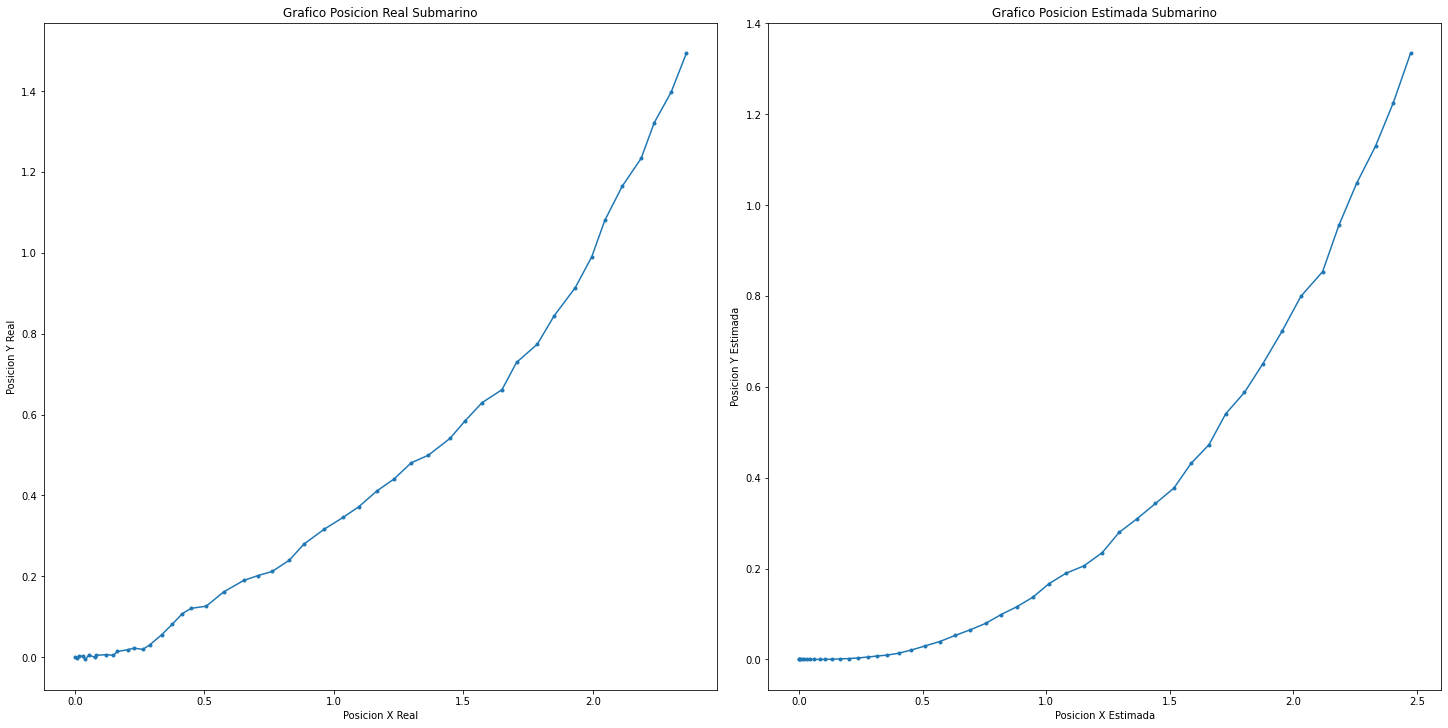

In [ ]:
ukf_function([2,3])

Este caso es muy interesante dado que no se tiene información sobre la velocidad angular, que vimos anteriormente que permitia modelar la altura a la que se encuentra el submarino, pero al actualizar con el Compass y los Encoders, se logra tener una curva que a simple vista representa bastante fidedignamente lo que es la posicion real del submarino, incluyendo los cambios de pendiente en la curva.

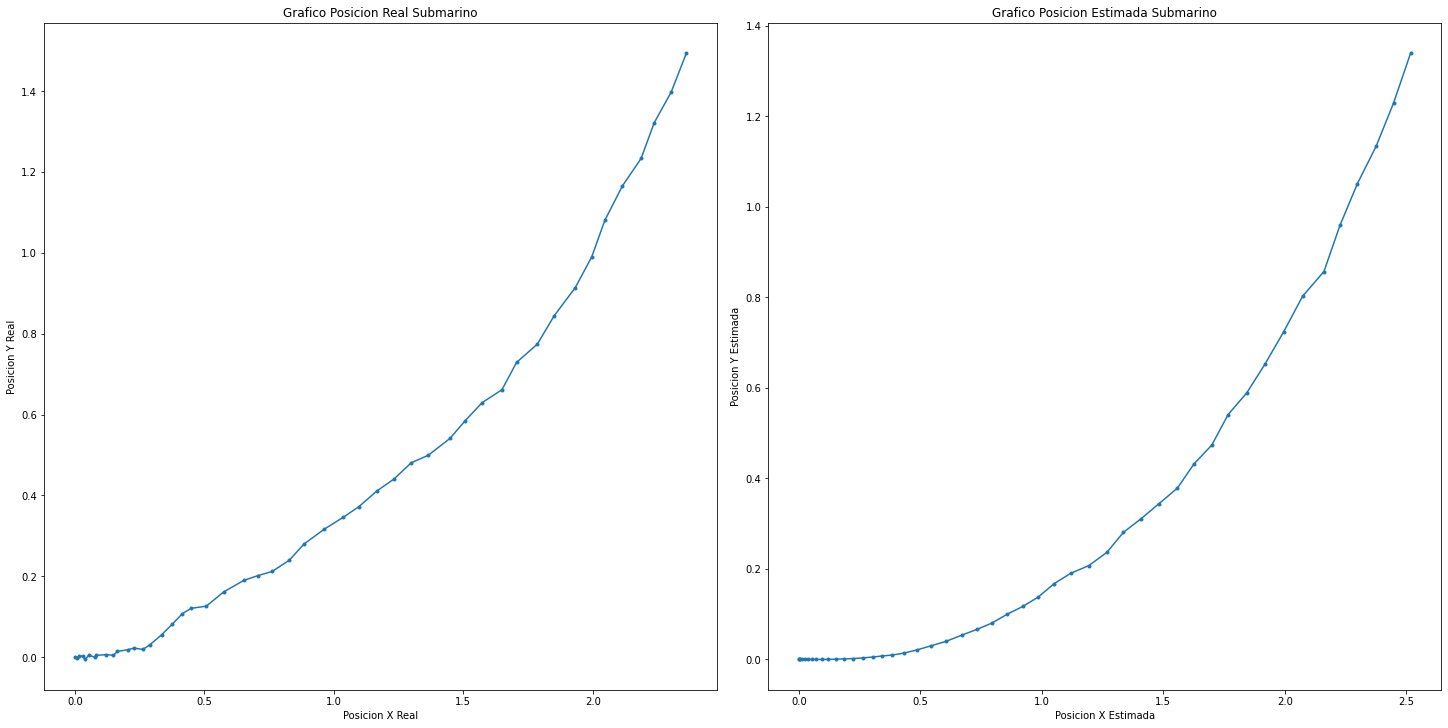

In [ ]:
ukf_function([3,2])

En este ultimo grafico, se puede ver que no afecta el sentido u orden en el cual se aplican los updates de los sensores, ya que el resultado es el mismo grafico que en el caso anterior, en el cual se usaba Compass y Encoders, en este caso se ingreso Encoders y Compass.

###Parte 4 - Modificando la Covarianza:
En esta parte se modifico nuevamente el codigo, desde el codigo base entregado, pero esta vez se agregan 2 variables "model_cov" y "sense_cov", las cuales son factores por los que se multiplicara la covarianza base del programa para ver como esta modifica el grafico.

In [ ]:
from numpy.matrixlib.defmatrix import N
from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret

def ukf_cov(model_cov=None,sense_cov=None):
  np.set_printoptions(precision=3)

  q = np.eye(6)
  r_imu = np.zeros([2, 2])
  r_compass = np.zeros([1, 1])
  r_encoder = np.zeros([1, 1])

  if (model_cov or model_cov == 0):
    q[0][0] = 0.0001*model_cov
    q[1][1] = 0.0001*model_cov
    q[2][2] = 0.0004*model_cov
    q[3][3] = 0.0025*model_cov
    q[4][4] = 0.0025*model_cov
    q[5][5] = 0.0025*model_cov


  else:
    # Process Noise
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025


  if(sense_cov or sense_cov==0):
    r_imu[0][0] = 0.01*sense_cov
    r_imu[1][1] = 0.03*sense_cov

    r_compass[0][0] = 0.02*sense_cov

    r_encoder[0][0] = 0.001*sense_cov

  else:

    # create measurement noise covariance matrices

    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass[0][0] = 0.02

    r_encoder[0][0] = 0.001

  # pass all the parameters into the UKF!
  # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
  state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

  #Variables que se utilizaran para Graficar, se modifico el codigo solo para facilitar la creacion de los graficos, ademas de
  # arreglar un error con el metodo .next().
  real2 = []
  estimated2 = []
  difference2 = []

  with open('datos.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    last_time = 0
    # read data
    for row in reader:
      row = [float(x) for x in row]

      cur_time = row[0]
      d_time = cur_time - last_time
      real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

      # create an array for the data from each sensor
      compass_hdg = row[9]
      compass_data = np.array([compass_hdg])

      encoder_vel = row[10]
      encoder_data = np.array([encoder_vel])

      imu_accel = row[7]
      imu_yaw_rate = row[8]
      imu_data = np.array([imu_yaw_rate, imu_accel])

      last_time = cur_time

      # prediction is pretty simple
      state_estimator.predict(d_time)

      # updating isn't bad either
      # remember that the updated states should be zero-indexed
      # the states should also be in the order of the noise and data matrices
      state_estimator.update([4, 5], imu_data, r_imu)
      state_estimator.update([2], compass_data, r_compass)
      state_estimator.update([3], encoder_vel, r_encoder)

      #Se guardan los valores calculados en variables que seran utilizadas en el desarrollo de la tarea.

      real2.append(real_state)
      estimated2.append(state_estimator.get_state())
      difference2.append( real_state - state_estimator.get_state() )

    graph = plt.figure(figsize=(20, 10), layout='constrained')
    plot1 = graph.add_subplot(121)
    plot2 = graph.add_subplot(122)

    realx = []
    realy = []
    estimatedx = []
    estimatedy = []

    for i in range(len(real)):
      realx.append(real2[i][0])
      realy.append(real2[i][1])
      estimatedx.append(estimated2[i][0])
      estimatedy.append(estimated2[i][1])


    plot1.plot(realx,realy,marker=".")
    plot1.set_xlabel('Posicion X Real')
    plot1.set_ylabel('Posicion Y Real')
    plot1.set_title("Grafico Posicion Real Submarino")

    plot2.plot(estimatedx,estimatedy,marker=".")
    plot2.set_xlabel('Posicion X Estimada')
    plot2.set_ylabel('Posicion Y Estimada')
    plot2.set_title("Grafico Posicion Estimada Submarino")

Se grafica primero el caso base para tener una referencia cercana:

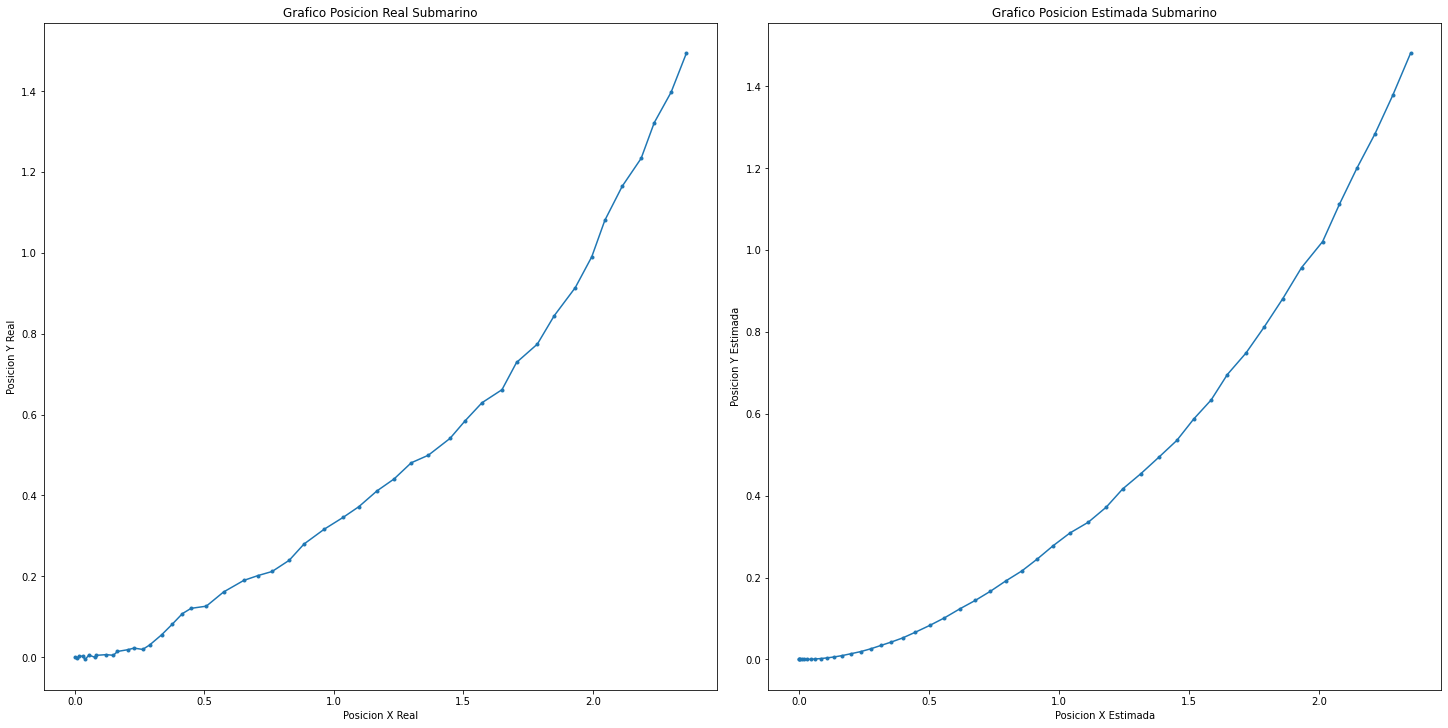

In [ ]:
ukf_cov()

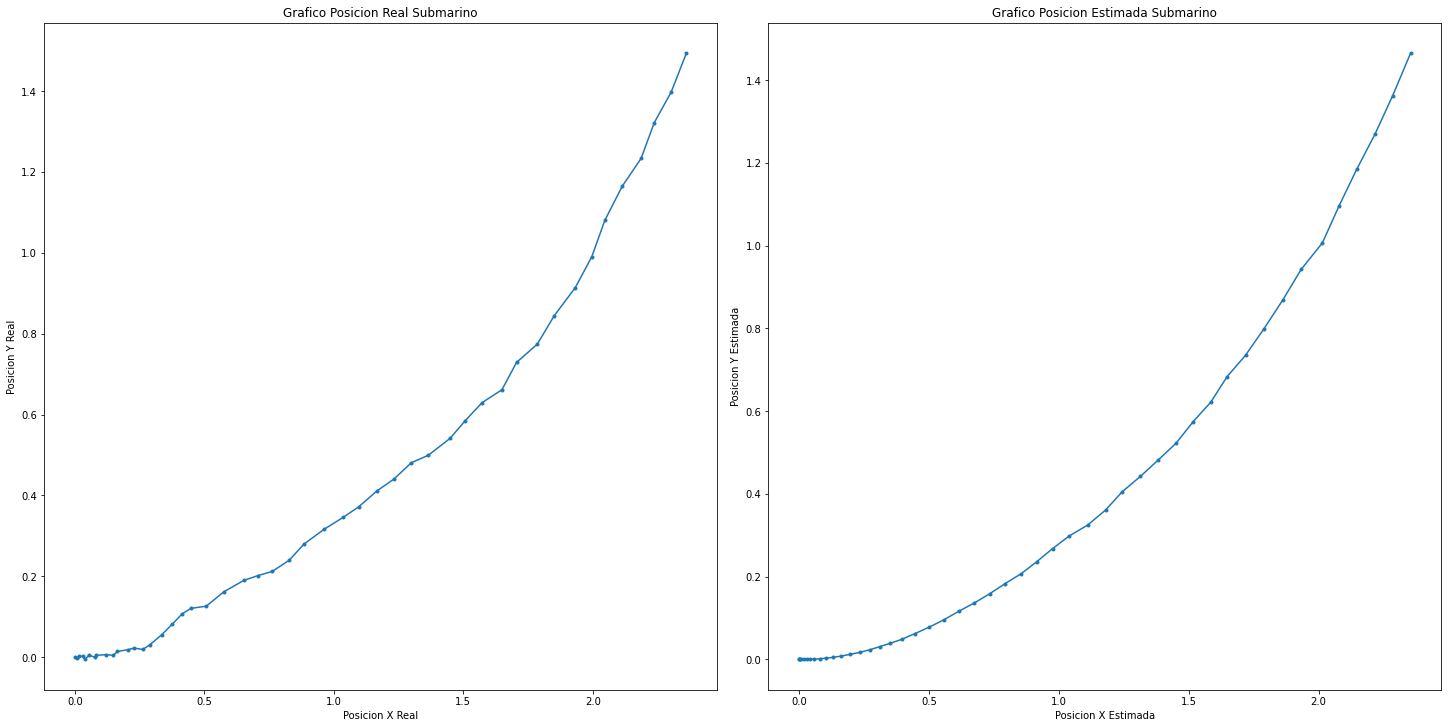

In [ ]:
ukf_cov(5,5)

Podemos ver que al multiplicar las covarianzas por 5, tanto del modelo como la de los sensore, no cambia mucho el grafico, esto tiene sentido dado a que la principal interpretacion de la covarianza viene dada segun su positividad o negatividad, ya que relaciona el comportamiento de 2 variables, ya sean directa o inversamente proporcionales. Entonces un aumento pequeño en la magnitud no modifica mucho el comportamiento del grafico.

Ahora que ocurrira si es que se multiplican por valores muy grandes?

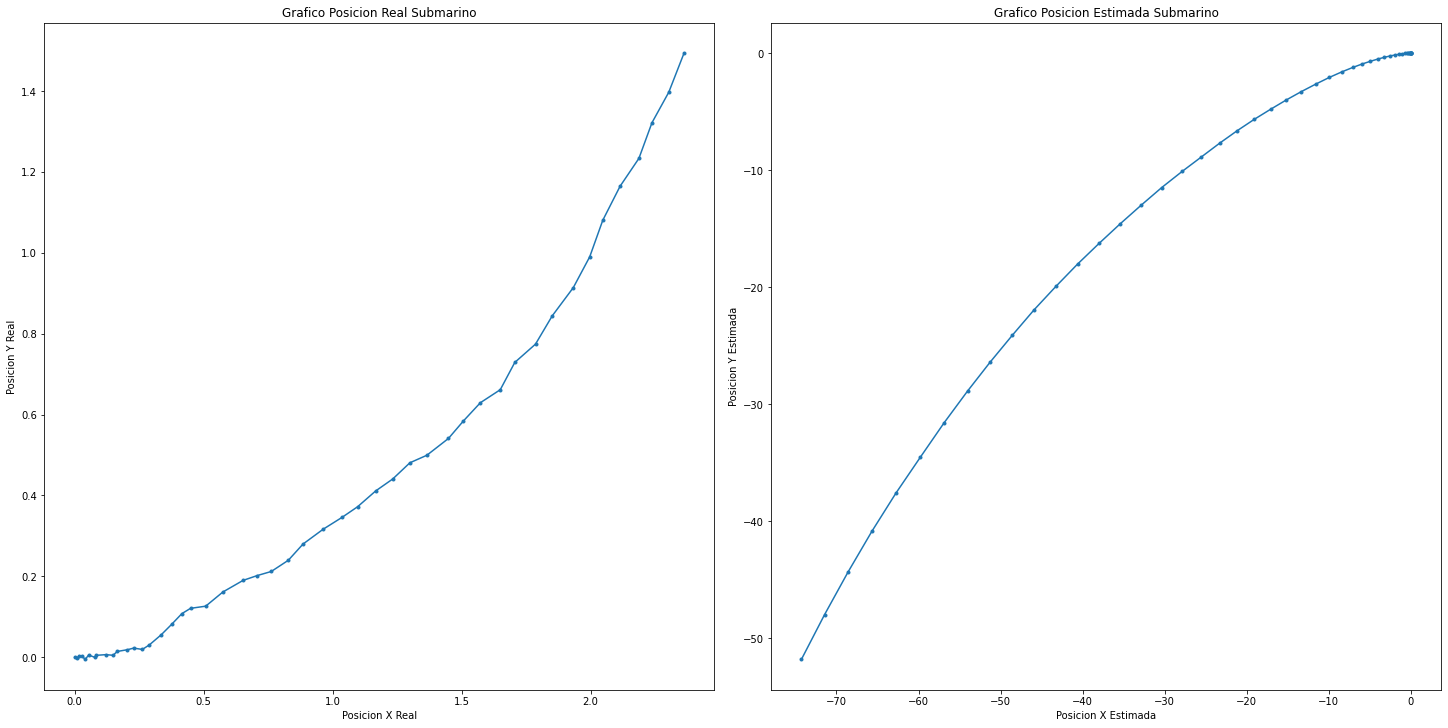

In [ ]:
ukf_cov(100000,100000)

Podemos observar que el crecimiento de la curva se invierte, la curva se vuelve mas "lisa" o se asemeja mas a e^x ,ademas de que el grafico parte desde los negativos y tiende a 0, por otra parte dado que el grafico se invirtio y esto representa la relacion entre 2 variables, podriamos inferir que una de las variables (en este caso la posicion Y) crece mas rapidamente que la otra (La posicion en X) y que ademas a medida que se acerca al 0, esta crece mas lentamente y en el caso original ocurre de forma opuesta, primero crece muy lento y luego muy rapido.

Ahora si solo una covarianza aumenta mucho que ocurre?


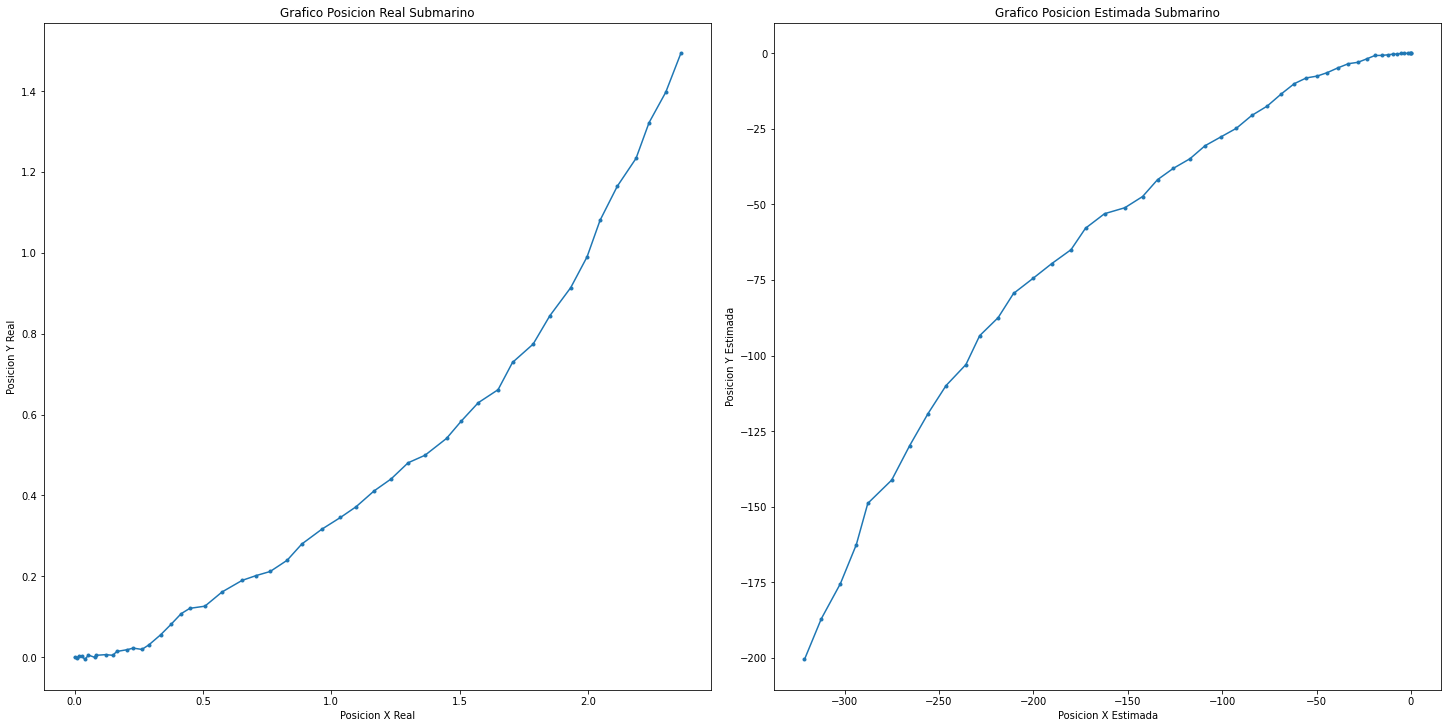

In [ ]:
ukf_cov(100000000000,100000)

Este caso resulta muy interesante tambien, dado que ademas de que se invierte curva, al igual que en el caso anterior, en este la curva no se "alisa", si no que mantiene sus imperfecciones, ademas se puede observar que aumenta la magnitud de los negativos desde donde parte el grafico.

/content/ukf.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1] = self.x + spr_mat[i]
/content/ukf.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1+self.n_dim] = self.x - spr_mat[i]


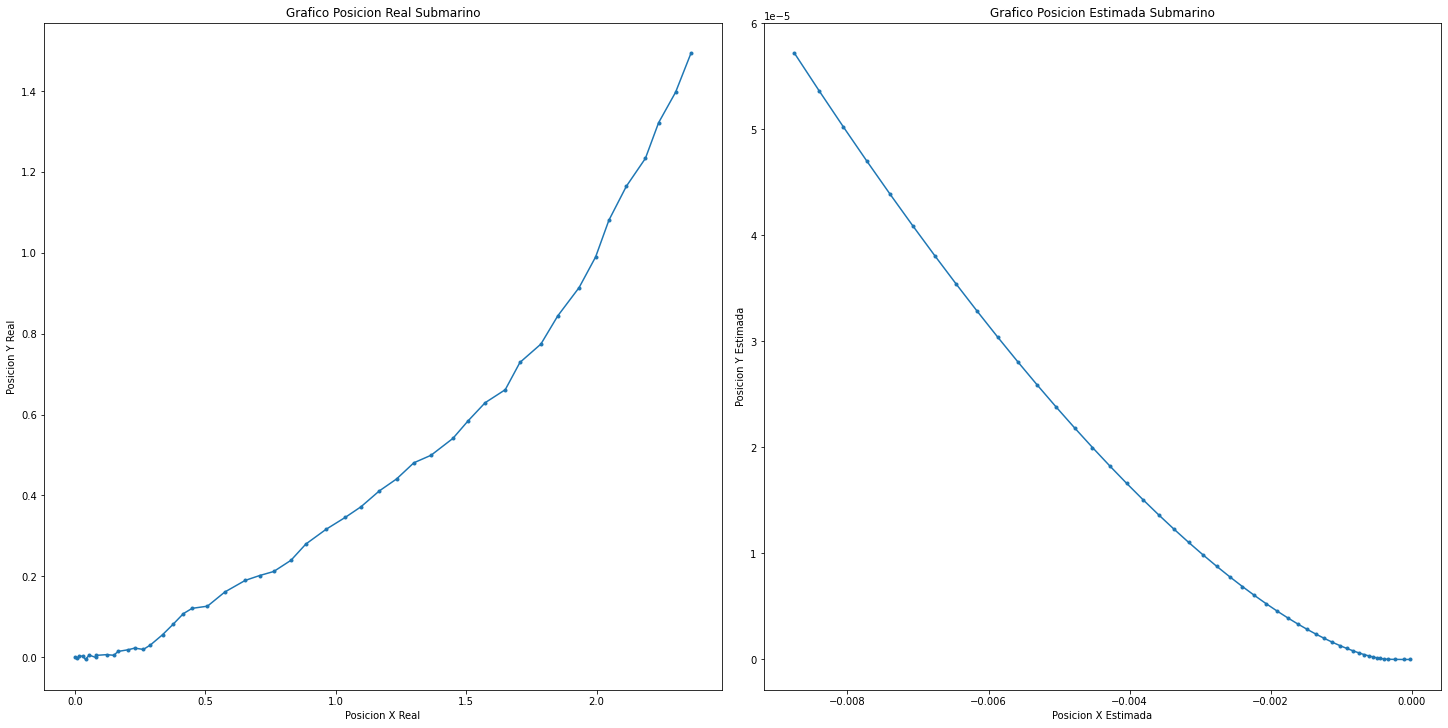

In [ ]:
ukf_cov(-1,-1)

Por otra parte si hacemos que la covarianza ahora sea negativa, esto hace que las variables sean inversamente proporcionales y por eso se invierte la curva y en vez de ser creciente, se vuelve decreciente, sufriendo tambien este efecto de "alisado" o "suavizado".

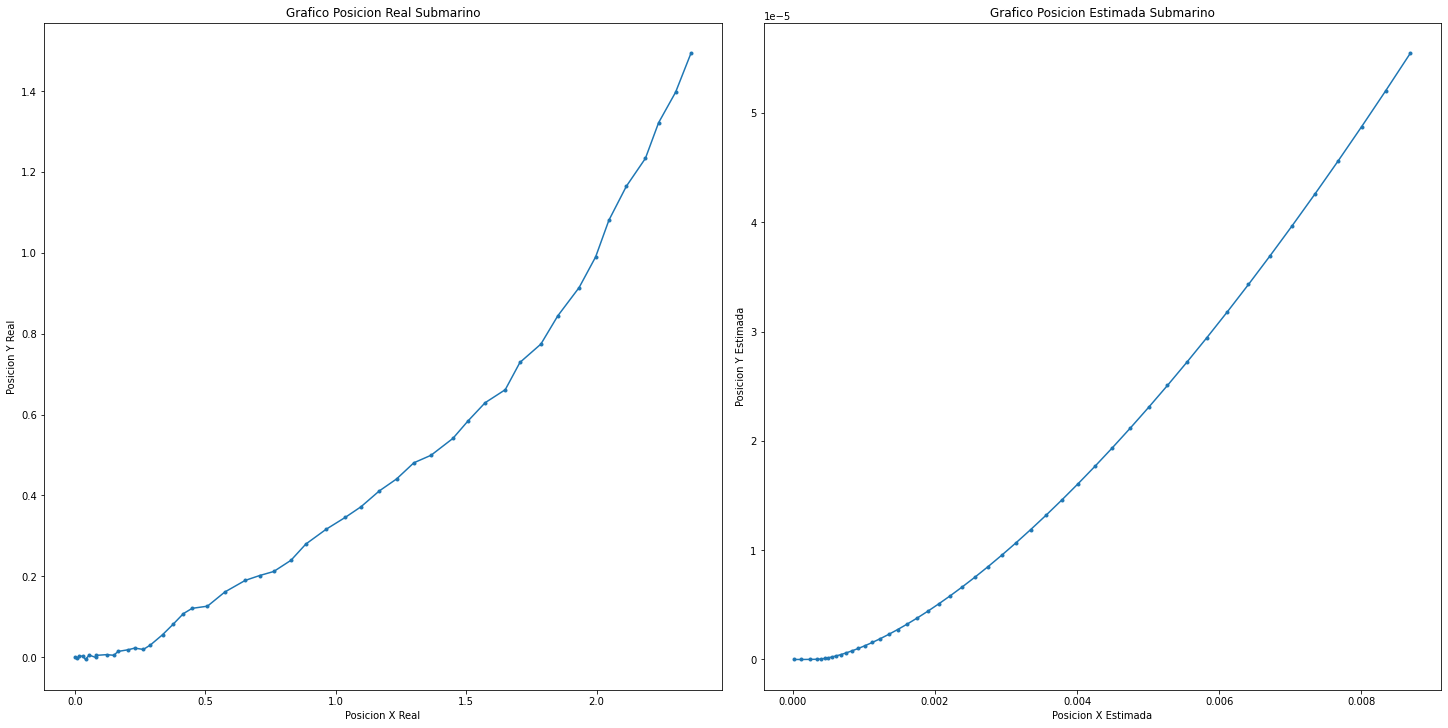

In [ ]:
ukf_cov(-1,1)

En el caso en el que solo hacemos que la covarianza del ruido del modelo sea negativa, la curva sufre este efecto de suavizado, esto puede que este relazionado directamente con esto, dado que si hay "ruido negativo", me da la idea de que es un ruido que no interfiere o no molesta, por esto la grafica muestra su version mas "lisa".

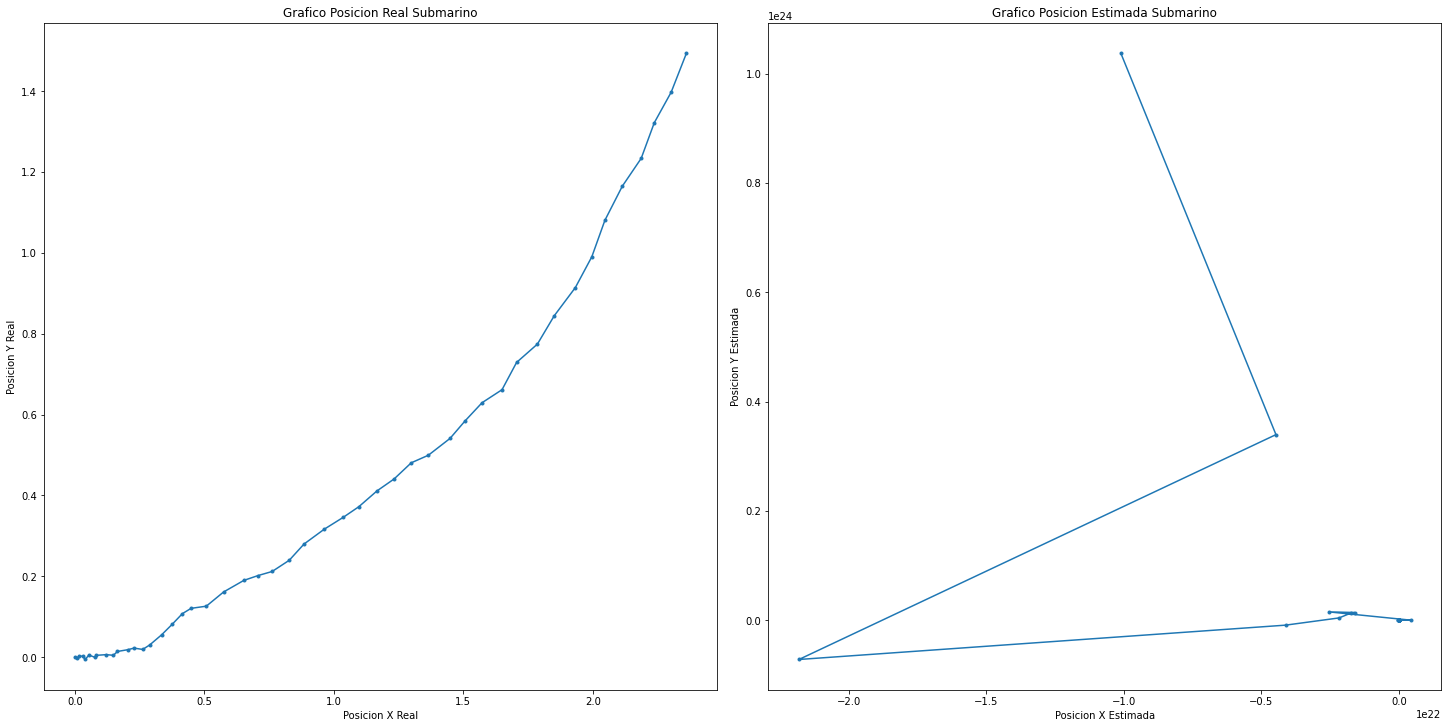

In [ ]:
ukf_cov(1,-1)

Ahora en el caso en que solo la covarianza de los sensores sea negativa, se genera un grafico muy raro en el cual no pareciera haber alguna relacion (o al menos con mis conocimientos no se me ocurre una).

Se procede a ver que es lo que pasa si es que alguna de las covarianzas o ambas son 0.

In [ ]:
try:
  ukf_cov(0,0)

except Exception as error:
  print(error)

Singular matrix


El primer caso en el que ambas son 0, se introdujo en un try-except, dado que retornaba un error por matriz singular, dando la impresion de que los valores de las covarianzas no pueden se 0, lo cual implicaria que las variables deben tener algun grado de relacion entre ellas.

Se procede entonces a probar con alguna que sea 0:

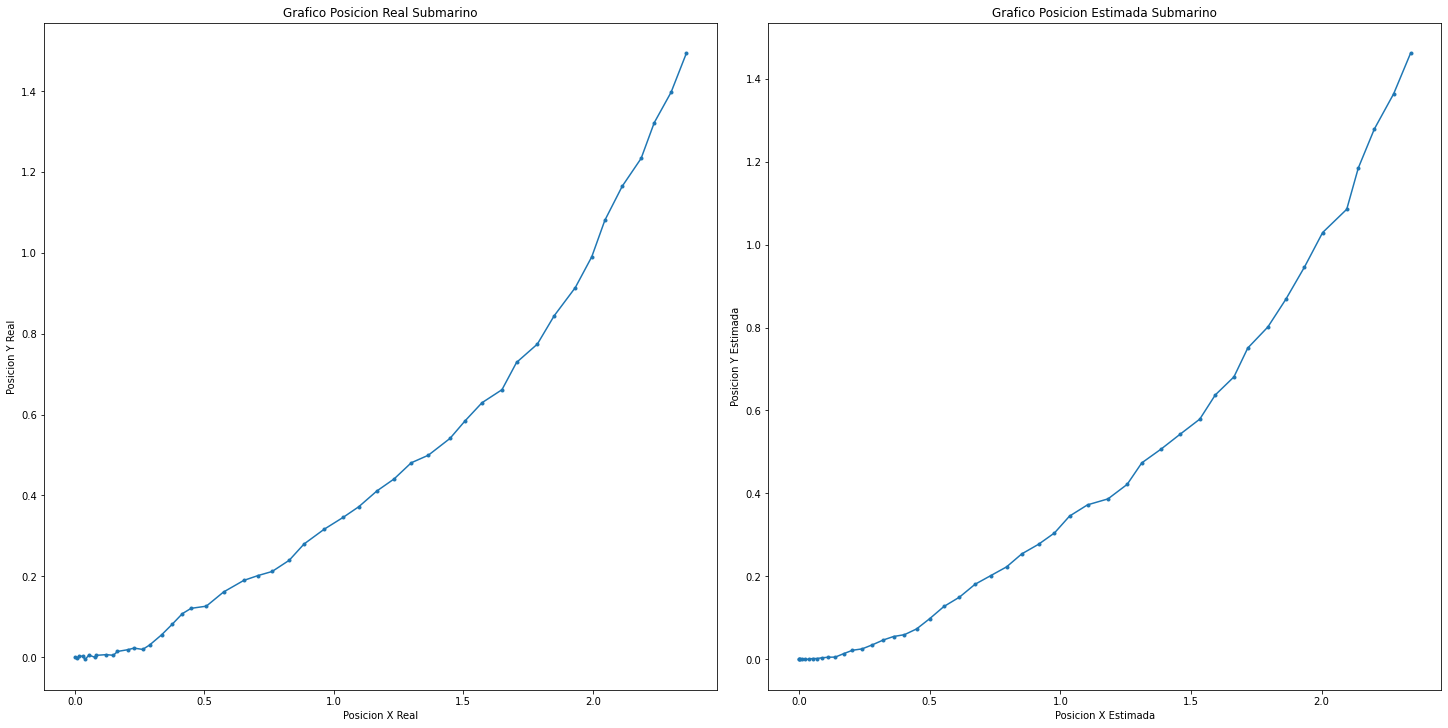

In [ ]:
ukf_cov(1,0)

En el caso en que la covarianza de los sensores sea 0, si retorna un grafico (luego de un warning por las operaciones a realizar), y se ven pequeñas modificaciones del grafico original de mas arriba, de hecho se ve que el grafico tiene mas cambios de pendiente.

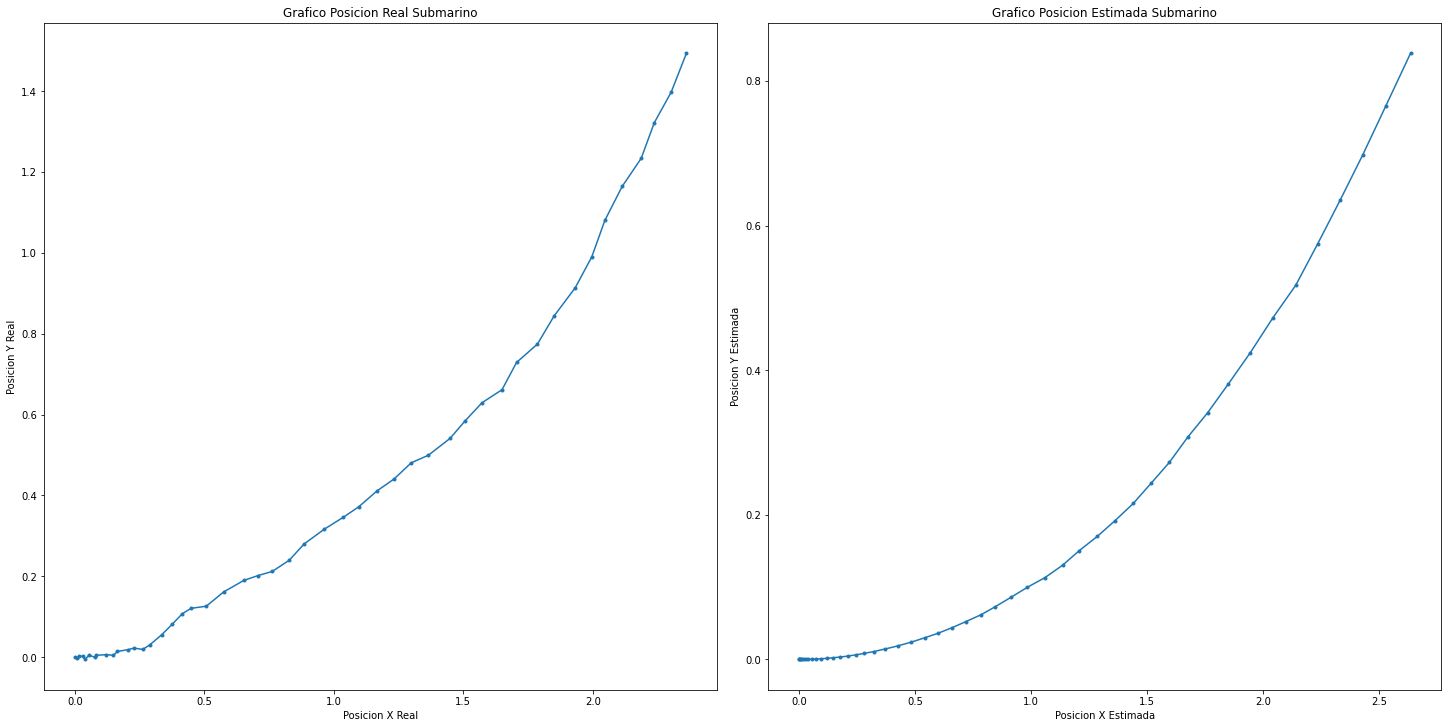

In [ ]:
ukf_cov(0,1)

Por otra parte y finalmente, se puede observar que si la covarianza del ruido es 0, ocurre este caso de suavizado que se hablaba anteriormente, pero no de forma tan "perfecta", dado que si observamos cerca de x=2 o x=1, podemos notar que hay ciertos cambios bruscos de pendiente, pero sigue siendo una curva mucho menos cambiante que la original.

##Referencias:
[1] - https://en.wikipedia.org/wiki/Extended_Kalman_filter

[2] - Ribeiro, M. I. (2004). Kalman and extended kalman filters: Concept, derivation and properties. Institute for Systems and Robotics, 43, 46.

[3] - Wan, E. A., & van der Merwe, R. (n.d.). The Unscented Kalman Filter. Kalman Filtering and Neural Networks, 221–280. doi:10.1002/0471221546.ch7

[4] - Wan, E. A., & Van Der Merwe, R. (n.d.). The unscented Kalman filter for nonlinear estimation. Proceedings of the IEEE 2000 Adaptive Systems for Signal Processing, Communications, and Control Symposium (Cat. No.00EX373). doi:10.1109/asspcc.2000.882463

[5] - St-Pierre, M., & Gingras, D. (2004, June). Comparison between the unscented Kalman filter and the extended Kalman filter for the position estimation module of an integrated navigation information system. In IEEE Intelligent Vehicles Symposium, 2004 (pp. 831-835). IEEE.